In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import numpy as np
import time
import os
import matplotlib.pyplot as plt  

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchviz import make_dot
from utils import one_hot_encode, one_hot_decode, get_all_amino_acids, get_wild_type_amino_acid_sequence
from utils import load_gfp_data, count_substring_mismatch, get_mutation

In [2]:
class VAE(nn.Module):
    
    # change architecture later to make it deeper if it's not good enough to capture all data
    def __init__(self, input_size, hidden_size, latent_dim, num_characters, seq_length):
        super(VAE, self).__init__() 
        self.num_characters = num_characters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        self.seq_length = seq_length
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_dim)
        self.fc22 = nn.Linear(hidden_size, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)
        
    def encode(self, x):
        # input should be one hot encoded. shape - (batch_size, alphabet x sequence_length)
        h1 = F.elu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, softmax=False):
        batch_size = z.shape[0]
        h3 = F.elu(self.fc3(z))
        if softmax:
            return F.softmax(self.fc4(h3).view(batch_size, -1, self.num_characters), dim=2)
        else:
            return self.fc4(h3).view(batch_size, -1, self.num_characters)
        
    def forward(self, x):
        """
        Input: x is the one hot encoded batch_size x (seq_length * num_characters)
        Output: recon_x: is the one hot encoded batch_size x seq_length x num_characters vector
                mu: is the hidden state mean with dimension batch_size x hidden_size
                logvar: is the hidden state log variance with dimension batch_size x hidden_size
        """
        mu, logvar = self.encode(x.view(-1, self.input_size))
        z = self.reparameterize(mu, logvar)
        return self.decode(z, softmax=False), mu, logvar

    def elbo_loss(self, recon_x, x, mu, logvar):
        """
        Input: x is the one hot encoded batch_size x (seq_length * num_characters) 
               recon_x is the unormalized outputs of the decoder in the same shape as x
               mu and logvar are the hidden states of size self.hidden_size
        Output: elbo_loss
        """
        outputs = F.log_softmax(recon_x, dim = 2)
        CE = (-1 * outputs * x.view(x.shape[0], -1, self.num_characters)).sum()
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return CE + KLD
    
    def cross_entropy_loss(self, recon_x, x):
        loss = nn.CrossEntropyLoss(reduction='sum')
        input = recon_x.permute(0, 2, 1)
        _, target = x.view(x.shape[0], -1, self.num_characters).max(dim=2)
        target = target.long()
        return loss(input, target)
    
    def kld_loss(self, mu, logvar): 
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    

In [59]:
torch.manual_seed(np.random.randint(0, 1000))
train_losses, test_losses, train_kld_loss, test_kld_loss, train_recon_loss, test_recon_loss = [], [], [], [], [], []
model = VAE(21 * 238, 50, 20, 21, 238)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, eps=1e-9)
start_time = time.time()
name = "base_vae_implementation"
epochs = 200
#logger = open("./logs/vae/{0}_epochs_{1}.txt".format(name, epochs), "w")
logger = None
for epoch in range(1, epochs + 1):
    train_loss, reconstruction_loss, kld_loss = 0, 0, 0
    model.train()
    for batch_idx, (x, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        rloss, kloss = model.cross_entropy_loss(recon_x, x), model.kld_loss(mu, logvar)
        loss = (rloss + kloss) / x.shape[0]
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.shape[0]
        reconstruction_loss += rloss.item()
        kld_loss += kloss.item()
    kld_loss /= len(train_loader.dataset)
    reconstruction_loss /= len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)
    print('<-- Epoch: {0}. Average Train loss: {1:.4f}. Train Reconstruction loss: {2:.4f}. Train KLD loss: {3:.4f}. Time: {4:.2f}'.format(
                    epoch, train_loss, reconstruction_loss, kld_loss, time.time() - start_time), file=logger)
    
    train_losses.append(train_loss); train_kld_loss.append(kld_loss); train_recon_loss.append(reconstruction_loss)
    model.eval()
    test_loss, reconstruction_loss, kld_loss = 0, 0, 0
    for batch_idx, (x, _) in enumerate(test_loader):
        recon_x, mu, logvar = model(x)
        rloss, kloss = model.cross_entropy_loss(recon_x, x), model.kld_loss(mu, logvar)
        loss = rloss + kloss
        test_loss += loss.item() 
        reconstruction_loss += rloss.item()
        kld_loss += kloss.item()
    kld_loss /= len(test_loader.dataset)
    reconstruction_loss /= len(test_loader.dataset)
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss); test_kld_loss.append(kld_loss); test_recon_loss.append(reconstruction_loss)
    print('<-- Epoch: {0}. Average Test loss: {1:.4f}. Test Reconstruction loss: {2:.4f}. Test KLD loss: {3:.4f}. Time: {4:.2f}'.format(
                    epoch, test_loss, reconstruction_loss, kld_loss, time.time() - start_time), file=logger)
logger.close()

<-- Epoch: 1. Average Train loss: 361.9162. Train Reconstruction loss: 311.8846. Train KLD loss: 50.0316. Time: 0.67
<-- Epoch: 1. Average Test loss: 72.0480. Test Reconstruction loss: 37.8204. Test KLD loss: 34.2276. Time: 0.94
<-- Epoch: 2. Average Train loss: 54.4651. Train Reconstruction loss: 31.9867. Train KLD loss: 22.4784. Time: 1.71
<-- Epoch: 2. Average Test loss: 46.8714. Test Reconstruction loss: 29.4565. Test KLD loss: 17.4149. Time: 1.86
<-- Epoch: 3. Average Train loss: 43.7549. Train Reconstruction loss: 28.6818. Train KLD loss: 15.0731. Time: 2.53
<-- Epoch: 3. Average Test loss: 41.9575. Test Reconstruction loss: 30.4938. Test KLD loss: 11.4637. Time: 2.70
<-- Epoch: 4. Average Train loss: 38.7758. Train Reconstruction loss: 27.1687. Train KLD loss: 11.6071. Time: 3.29
<-- Epoch: 4. Average Test loss: 38.3307. Test Reconstruction loss: 27.7261. Test KLD loss: 10.6046. Time: 3.45
<-- Epoch: 5. Average Train loss: 36.7768. Train Reconstruction loss: 26.6779. Train KLD l

<-- Epoch: 37. Average Train loss: 26.8933. Train Reconstruction loss: 23.9648. Train KLD loss: 2.9286. Time: 31.25
<-- Epoch: 37. Average Test loss: 29.6100. Test Reconstruction loss: 26.4433. Test KLD loss: 3.1668. Time: 31.40
<-- Epoch: 38. Average Train loss: 26.4572. Train Reconstruction loss: 23.7079. Train KLD loss: 2.7493. Time: 31.99
<-- Epoch: 38. Average Test loss: 28.9858. Test Reconstruction loss: 26.3100. Test KLD loss: 2.6758. Time: 32.13
<-- Epoch: 39. Average Train loss: 26.4463. Train Reconstruction loss: 23.7682. Train KLD loss: 2.6782. Time: 32.72
<-- Epoch: 39. Average Test loss: 29.1243. Test Reconstruction loss: 26.3120. Test KLD loss: 2.8123. Time: 32.98
<-- Epoch: 40. Average Train loss: 26.4711. Train Reconstruction loss: 23.6444. Train KLD loss: 2.8267. Time: 33.59
<-- Epoch: 40. Average Test loss: 29.1774. Test Reconstruction loss: 26.4046. Test KLD loss: 2.7728. Time: 33.74
<-- Epoch: 41. Average Train loss: 26.3737. Train Reconstruction loss: 23.6927. Trai

<-- Epoch: 73. Average Train loss: 24.2902. Train Reconstruction loss: 22.8380. Train KLD loss: 1.4522. Time: 58.81
<-- Epoch: 73. Average Test loss: 27.0808. Test Reconstruction loss: 25.6165. Test KLD loss: 1.4642. Time: 59.08
<-- Epoch: 74. Average Train loss: 24.1341. Train Reconstruction loss: 22.7150. Train KLD loss: 1.4191. Time: 59.90
<-- Epoch: 74. Average Test loss: 26.8719. Test Reconstruction loss: 25.6586. Test KLD loss: 1.2133. Time: 60.19
<-- Epoch: 75. Average Train loss: 24.3381. Train Reconstruction loss: 22.7772. Train KLD loss: 1.5609. Time: 60.97
<-- Epoch: 75. Average Test loss: 26.9258. Test Reconstruction loss: 25.4910. Test KLD loss: 1.4347. Time: 61.26
<-- Epoch: 76. Average Train loss: 24.0829. Train Reconstruction loss: 22.7313. Train KLD loss: 1.3515. Time: 62.10
<-- Epoch: 76. Average Test loss: 26.9438. Test Reconstruction loss: 25.7005. Test KLD loss: 1.2433. Time: 62.42
<-- Epoch: 77. Average Train loss: 24.1107. Train Reconstruction loss: 22.7617. Trai

<-- Epoch: 109. Average Train loss: 22.6176. Train Reconstruction loss: 22.0910. Train KLD loss: 0.5266. Time: 87.91
<-- Epoch: 109. Average Test loss: 25.8617. Test Reconstruction loss: 25.5320. Test KLD loss: 0.3298. Time: 88.13
<-- Epoch: 110. Average Train loss: 22.6238. Train Reconstruction loss: 22.1096. Train KLD loss: 0.5143. Time: 88.62
<-- Epoch: 110. Average Test loss: 25.8384. Test Reconstruction loss: 25.4899. Test KLD loss: 0.3485. Time: 88.78
<-- Epoch: 111. Average Train loss: 22.5533. Train Reconstruction loss: 22.0425. Train KLD loss: 0.5108. Time: 89.26
<-- Epoch: 111. Average Test loss: 25.8307. Test Reconstruction loss: 25.5112. Test KLD loss: 0.3195. Time: 89.41
<-- Epoch: 112. Average Train loss: 22.5527. Train Reconstruction loss: 21.9892. Train KLD loss: 0.5635. Time: 89.91
<-- Epoch: 112. Average Test loss: 26.0849. Test Reconstruction loss: 25.7087. Test KLD loss: 0.3762. Time: 90.11
<-- Epoch: 113. Average Train loss: 22.4689. Train Reconstruction loss: 21.8

KeyboardInterrupt: 

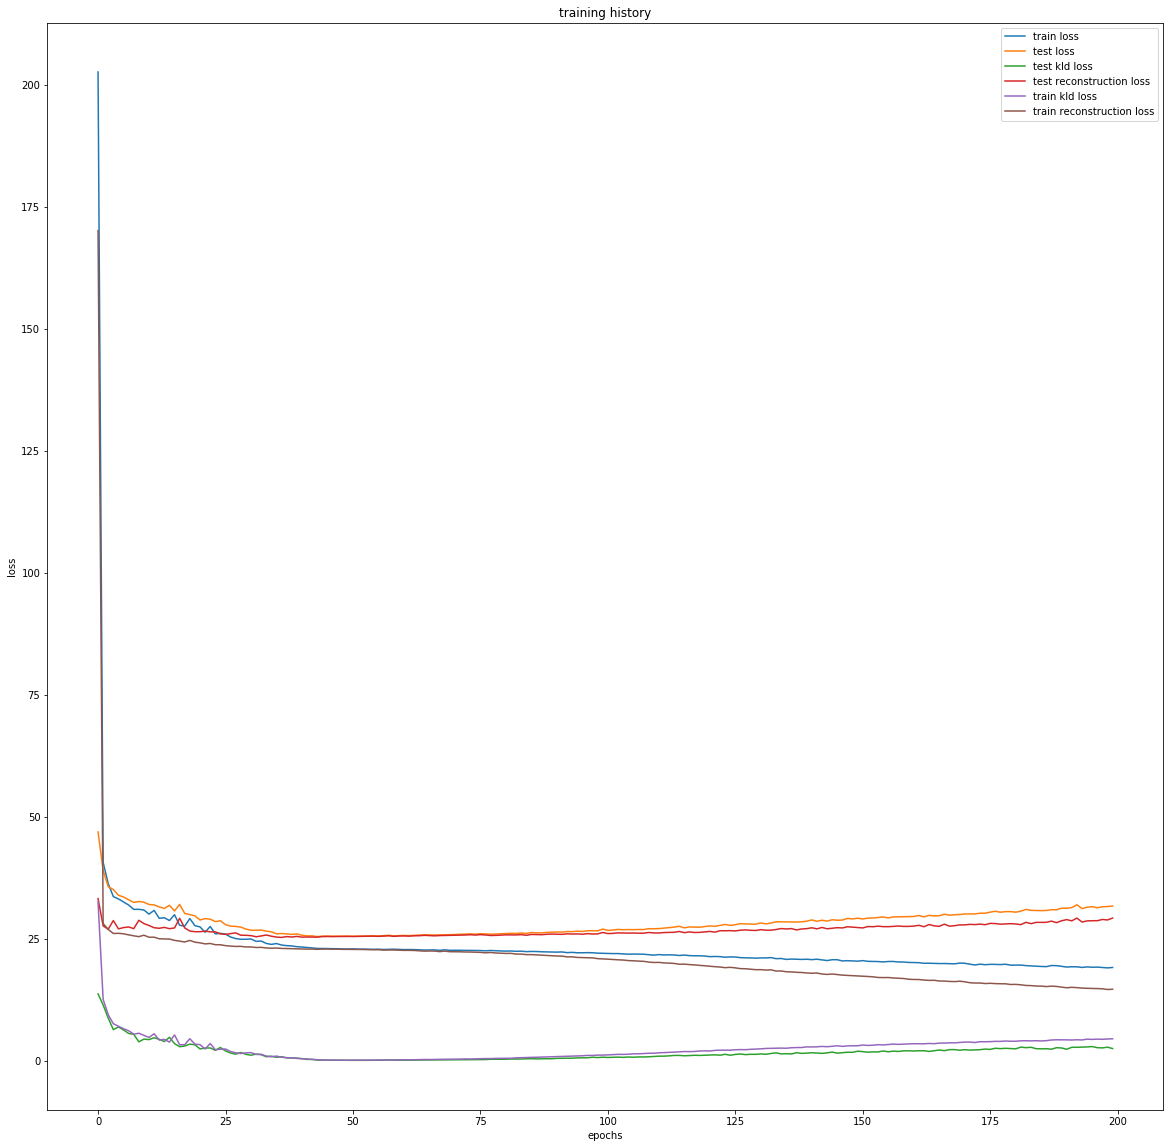

In [45]:
plt.figure(figsize = (20, 20))
losses = {
    "train loss" : train_losses,
    "test loss" : test_losses,
    "test kld loss" : test_kld_loss, 
    "test reconstruction loss" : test_recon_loss, 
    "train kld loss" : train_kld_loss,
    "train reconstruction loss" : train_recon_loss
}
for loss_name, loss in losses.items():
    plt.plot(loss, label = loss_name)
    
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title("training history")
plt.legend()
plt.savefig("./logs/{0}.png".format(name))

(1000, 238, 21)
finished 0/1000 samples
finished 100/1000 samples
finished 200/1000 samples
finished 300/1000 samples
finished 400/1000 samples
finished 500/1000 samples
finished 600/1000 samples
finished 700/1000 samples
finished 800/1000 samples
finished 900/1000 samples
SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYSYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*


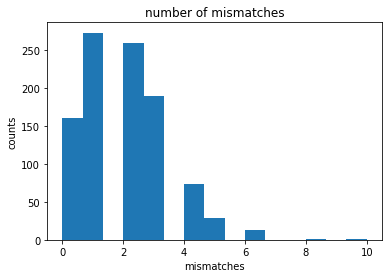

In [46]:
num_samples = 1000
vocabulary = get_all_amino_acids()
num_characters = len(get_all_amino_acids())
index_to_character = dict(zip(range(num_characters), vocabulary))
wild_type = get_wild_type_amino_acid_sequence()

z = np.random.sample((num_samples, 20))
outputs = model.decode(torch.tensor(z).float())
outputs = outputs.view(outputs.shape[0], -1, num_characters)
outputs = F.softmax(outputs, dim=2)
outputs = outputs.detach().numpy()
print(outputs.shape)
mismatches, all_strings = [], []
for i in range(outputs.shape[0]):
    string = []
    for j in range(outputs.shape[1]):
        k = np.random.choice(list(range(num_characters)), p = outputs[i, j])
        string.append(index_to_character[k])
    all_strings.append("".join(string))
    mismatches.append(count_substring_mismatch(wild_type, all_strings[-1]))
    if i % 100 == 0:
        print("finished {0}/{1} samples".format(i, num_samples))
print(all_strings[-1])
plt.title("number of mismatches")
plt.hist(mismatches, bins=15)
plt.xlabel("mismatches")
plt.ylabel("counts")
plt.savefig("./logs/vae/{0}_mismatches_from_wild_type".format(name))

In [66]:
class GenerativeVAE(): 
    
    def __init__(self, args):     
        """
        Initializes the VAE to be a generative VAE
        Parameters
        ----------
        args : dictionary
            defines the hyper-parameters of the neural network
        args.name : string 
            defines the name of the neural network
        args.description: string
            describes the architecture of the neural network
        args.input : int
            the size of the input
        args.hidden_size : int
            the size of the hidden layer
        args.latent_dim: int 
            the size of the latent dimension
        args.device : device
            the device used: cpu or gpu
        args.learning_rate : float
            sets the learning rate
        args.epochs : int 
            sets the epoch size 
        args.beta : float
            sets the beta parameter for the KL divergence loss
        args.vocabulary : string
            all the characters in the context of the problem
        args.seq_length : int 
            maximum seq length of the DNA sequence
        args.batch_size : int
            batch size of the model
        args.learning_rate : float
            initial learning rate
        """
        self.name = args["name"]
        self.description = args["description"]
        self.input = args["input"]
        self.hidden_size = args["hidden_size"]
        self.latent_dim = args["latent_dim"]
        self.device = args["device"]
        self.learning_rate = args["learning_rate"]
        self.epochs = args["epochs"]
        self.beta = args["beta"]
        self.all_characters = args["vocabulary"]
        self.seq_length = args["seq_length"]
        self.batch_size = args["batch_size"]
        self.learning_rate = args["learning_rate"]
        self.num_characters = len(self.all_characters)
        self.character_to_int = dict(zip(self.all_characters, range(self.num_characters)))
        self.int_to_character = dict(zip(range(self.num_characters), self.all_characters))
        self.model = VAE(self.input, self.hidden_size, self.latent_dim, self.num_characters, self.seq_length)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.train_loss_history = []
        self.test_loss_history = []
        assert(self.seq_length * self.num_characters == self.input)
        
    def elbo_loss(self, recon_x, x, mu, logvar):
        """
        Input: x is the one hot encoded batch_size x (seq_length * num_characters) 
               recon_x is the unormalized outputs of the decoder in the same shape as x
               mu and logvar are the hidden states of size self.hidden_size
        Output: elbo_loss
        """
        outputs = F.log_softmax(recon_x, dim = 2)
        CE = (-1 * outputs * x.view(x.shape[0], -1, self.num_characters)).sum()
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return CE + KLD
    
    def cross_entropy_loss(self, recon_x, x):
        loss = nn.CrossEntropyLoss(reduction='sum')
        input = recon_x.permute(0, 2, 1)
        _, target = x.view(x.shape[0], -1, self.num_characters).max(dim=2)
        target = target.long()
        return loss(input, target)
    
    def kld_loss(self, mu, logvar): 
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    def fit(self, train_dataloader, test_dataloader=None, verbose=True, logger=None, save_model=True):
        if not os.path.isdir("./models/{0}".format(self.name)):
            os.mkdir("./models/{0}".format(self.name))
        start_time = time.time()
        self.train_loss_history, self.test_loss_history = [], []
        self.test_recon_loss_history, self.test_kld_loss_history = [], []
        self.train_recon_loss_history, self.train_kld_loss_history = [], []
        for epoch in range(1, self.epochs + 1):
            #train model 
            self.model.train()
            total_train_loss, total_recon_loss, total_kld_loss = 0, 0, 0
            for batch_idx, (x, _) in enumerate(train_dataloader):
                x = x.to(self.device)
                self.optimizer.zero_grad()
                recon_x, mu, logvar = self.model(x)
                rloss, kloss = self.cross_entropy_loss(recon_x, x), self.kld_loss(mu, logvar)
                loss = (rloss + kloss) / (x.shape[0])
                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item() * x.shape[0] 
                total_recon_loss += rloss.item()
                total_kld_loss += kloss.item()
            self.train_loss_history.append(total_train_loss / len(train_dataloader.dataset))
            self.train_recon_loss_history.append(total_recon_loss / len(train_dataloader.dataset))
            self.train_kld_loss_history.append(total_kld_loss / len(train_dataloader.dataset))
            
            #evaluate model
            self.model.eval()
            if verbose: 
                print('<====> Epoch: {0}. Average loss: {1:.4f}. Reconstruction loss: {2:.4f}. KLD loss: {3:.4f}. Time: {4:.2f} seconds'.format(
                      epoch, self.train_loss_history[-1], self.train_recon_loss_history[-1], self.train_kld_loss_history[-1], time.time() - start_time), file = logger)
            if test_dataloader:
                test_loss, test_recon_loss, test_kld_loss = self.evaluate(test_dataloader, verbose, logger)
                self.test_loss_history.append(test_loss)
                self.test_recon_loss_history.append(test_recon_loss)
                self.test_kld_loss_history.append(test_kld_loss)
            if epoch % 50 == 0 and save_model:
                self.save_model(epoch, train_loss)
                print("finished saving model", file=logger)
     
    def sample_tensor_to_string(self, x, softmax=False):
        assert(type(x) == torch.Tensor)
        assert(x.shape[0] % self.num_characters == 0 or x.shape[1] % self.num_characters == 0)
        x = x.reshape(-1, self.num_characters)
        if softmax:
            x = F.softmax(x, dim=1)
        string = []
        for dist in x: 
            index = torch.multinomial(dist, 1).item()
            string.append(self.int_to_character[index])
        return "".join(string)
    
    def tensor_to_string(self, x):
        """
        Input: A sequence in tensor format
        Output: A sequence in string format
        Example: tensor_to_string(torch.tensor([0, 0, 1, 0, 0, 0, 1, 0])) = "TT"
        tensor_to_string(torch.tensor([0.8, 0.15, 0.05, 0, 0, 0.9, 0.1, 0])) = "AC"
        note: alphabet is "ACTG" in this example
        """
        assert(type(x) == torch.Tensor)
        assert(len(x) % self.num_characters == 0)
        x = x.reshape(-1, self.num_characters)
        _, index = x.max(dim = 1)
        return "".join([self.int_to_character[i] for i in index.numpy()])
        
    def predict_elbo_prob(self, sequences, string=True):
        """
        Input: list of sequences in string or one_hot_encoded form
        Output: list of the elbo probability for each sequence
        Example: predict_elbo_prob(["ACT", "ACG"]) = [0.2, 0.75]
        predict_elbo_prob([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],  
                        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]]) = [0.2, 0.75]
        note: alphabet in this example is ACTG and the wild type is probably ACG***
        """
        if string: 
            sequences = one_hot_encode(sequences, self.all_characters)
        if type(sequences) != torch.Tensor:
            x = self.to_tensor(sequences)
        recon_x, mu, logvar = self.model(x)
        return self.elbo_loss(recon_x, x, mu, logvar)
    
    def evaluate(self, dataloader, verbose=True, logger=None):
        self.model.eval()
        total_test_loss, total_recon_loss, total_kld_loss = 0, 0, 0
        for i, (x, _) in enumerate(dataloader):
            x = x.to(self.device)
            recon_x, mu, logvar = self.model(x)
            rloss, kloss = self.cross_entropy_loss(recon_x, x), self.kld_loss(mu, logvar)
            total_recon_loss += rloss
            total_kld_loss += kloss
            total_test_loss += rloss + kloss
        total_test_loss /= len(dataloader.dataset)
        total_recon_loss /= len(dataloader.dataset)
        total_kld_loss /= len(dataloader.dataset)
        if verbose: 
            print('Test set loss: {0:.4f} Reconstruction loss: {1:.4f}. KLD loss: {2:.4f} <====>'.format(
                total_test_loss, total_recon_loss, total_kld_loss), file=logger)
        return total_test_loss.item(), total_recon_loss.item(), total_kld_loss.item()
    
    def to_tensor(self, x): 
        assert(type(x) == np.ndarray)
        return torch.from_numpy(x).float().to(self.device)
    
    def decoder(self, z, softmax=False):
        """ Note that the outputs are unnormalized """
        assert(z.shape[1] == self.latent_dim)
        if type(z) != torch.Tensor:
            z = self.to_tensor(z)
        return self.model.decode(z, softmax=softmax)
    
    def encoder(self, x, reparameterize=False): 
        assert(x.shape[1] == self.input)
        if type(x) != torch.Tensor:
            x = self.to_tensor(x)
        mu, log_var = self.model.encode(x)
        if reparameterize: 
            return self.model.reparameterize(mu, log_var), mu, log_var
        else: 
            return mu, log_var
        
    def sample(self, num_samples = 1, z = None, softmax=True): 
        if z is None: 
            z = torch.randn(num_samples, self.latent_dim).to(self.device)
        return self.decoder(z, softmax=softmax), z
            
    def load_model(self, model_path):
        checkpoint = torch.load(model_path)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    def save_model(self, epoch=None, loss=None): 
        torch.save({
                    'epoch': epoch,
                    'loss': loss,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict()
                }, "./models/{0}/checkpoint_{1}.pt".format(self.name, epoch))

    def show_model(self, logger=None): 
        print(self.model, file=logger)
    
    def plot_model(self, save_dir, verbose=False): 
        x = np.random.randn(self.batch_size, self.seq_length, self.num_characters)
        x = self.to_tensor(x)
        out, _, _ = self.model(x)
        graph = make_dot(out)
        if save_dir is not None:
            graph.format = "png"
            graph.render(save_dir) 
        if verbose:
            graph.view()
            
    def print_vars(self):
        print(self.__dict__)
        
    def plot_history(self, save_fig_dir): 
        plt.figure()
        plt.title("{0} Training Loss Curve".format(self.name))
        for name, history_lst in self.__dict__.items():
            if "history" in name:
                plt.plot(history_lst, label = name)
        print(save_fig_dir)
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel("loss")
        if save_fig_dir:
            plt.savefig(save_fig_dir)
        plt.show()

In [67]:
def get_test_args():
    args = {
        "name" : "vae_david_debug_epochs_100_data_900",
        "input" : 21 * 238, 
        "hidden_size" : 50,
        "latent_dim" : 20,
        "device" : torch.device("cpu"),
        "learning_rate" : 0.001,
        "epochs" : 2,
        "beta" : 1.0,
        "vocabulary" : get_all_amino_acids(),
        "num_data" : 900, 
        "batch_size" : 20,
        "seq_length" : 238,
    }
    args["description"] = "name: {0}, input size {1}, hidden size {2}, latent_dim {3}, lr {4}, epochs {5}".format(
                args["name"], args["input"], args["hidden_size"], args["latent_dim"], args["learning_rate"], args["epochs"])

    return args

In [68]:
X_train, X_test, y_train, y_test = load_gfp_data("./data/gfp_amino_acid_shuffle_")
args = get_test_args()
amino_acid_alphabet = get_all_amino_acids()
amino_acid_wild_type = get_wild_type_amino_acid_sequence()
one_hot_X_train = one_hot_encode(X_train[:args["num_data"]], amino_acid_alphabet)
one_hot_X_test = one_hot_encode(X_test[:args["num_data"]], amino_acid_alphabet)
y_train, y_test = y_train[:args["num_data"]], y_test[:args["num_data"]]
train_dataset = TensorDataset(torch.from_numpy(one_hot_X_train).float(), torch.from_numpy(y_train.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(one_hot_X_test).float(), torch.from_numpy(y_test.reshape(-1, 1)).float())
train_loader, test_loader = DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True), DataLoader(test_dataset, batch_size=args["batch_size"], shuffle=True)

vae_debug_batch_size_10_learning_rate_0.01
./logs/vae/vae_debug_batch_size_10_learning_rate_0.01_training_history.png


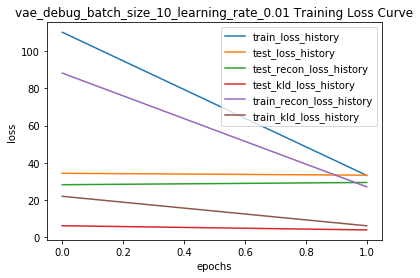

finished 0/1000 samples
finished 100/1000 samples
finished 200/1000 samples
finished 300/1000 samples
finished 400/1000 samples
finished 500/1000 samples
finished 600/1000 samples
finished 700/1000 samples
finished 800/1000 samples
finished 900/1000 samples
vae_debug_batch_size_10_learning_rate_0.01
./logs/vae/vae_debug_batch_size_30_learning_rate_0.01_training_history.png


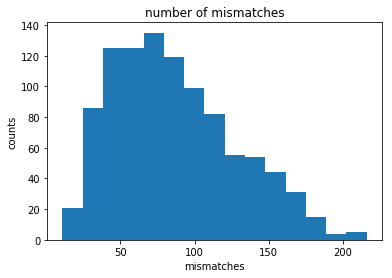

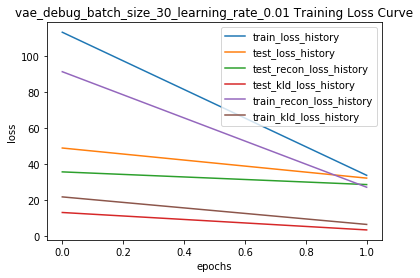

finished 0/1000 samples
finished 100/1000 samples
finished 200/1000 samples


KeyboardInterrupt: 

In [71]:
for learning_rate, batch_size in itertools.product([0.01, 0.003, 0.001, 0.0003], [10, 30]):
    name = "vae_debug_batch_size_{}_learning_rate_{}".format(batch_size, learning_rate)
    args["name"] = name
    args["batch_size"] = batch_size
    args["learning_rate"] = learning_rate
    torch.manual_seed(np.random.randint(0, 1000))
    print(vae.name)
    vae = GenerativeVAE(args)
    logger = open("./logs/vae/{0}.txt".format(vae.name), "w")
    vae.fit(train_loader, test_loader, True, logger, "./models/vae/{0}.txt".format(vae.name))
    vae.plot_model("./logs/vae/{0}_model_architecture".format(vae.name))
    vae.plot_history("./logs/vae/{0}_training_history.png".format(vae.name))
    vae.show_model(logger)
    if logger: 
        logger.close()
    num_samples = 1000
    vocabulary = get_all_amino_acids()
    num_characters = len(get_all_amino_acids())
    index_to_character = dict(zip(range(num_characters), vocabulary))
    wild_type = get_wild_type_amino_acid_sequence() 

    z = np.random.sample((num_samples, 20))
    outputs = vae.decoder(torch.tensor(z).float(), softmax=True)
    outputs = outputs.detach().numpy()
    mismatches, all_strings = [], []
    for i in range(outputs.shape[0]):
        string = []
        for j in range(outputs.shape[1]):
            k = np.random.choice(list(range(num_characters)), p = outputs[i, j])
            string.append(index_to_character[k])
        all_strings.append("".join(string))
        mismatches.append(count_substring_mismatch(wild_type, all_strings[-1]))
        if i % 100 == 0:
            print("finished {0}/{1} samples".format(i, num_samples))

    plt.title("number of mismatches")
    plt.hist(mismatches, bins=15)
    plt.xlabel("mismatches")
    plt.ylabel("counts")
    plt.savefig("./logs/vae/{0}_mismatches_from_wild_type.png".format(vae.name))

In [29]:
load_vae = GenerativeVAE(args)
load_vae.load_model("./models/{0}/checkpoint_500.pt".format(vae.name))
for parameter_name, load_weights in load_vae.model.state_dict().items():
    vae_weights = vae.model.state_dict()[parameter_name]
    assert(torch.all(torch.eq(load_weights, vae_weights)).item())

for (x, _) in test_loader:         
    x = x.to(load_vae.device)
    z, z_mean, z_var = load_vae.encoder(x, reparameterize=True)
    z_mean_2, z_var_2 = vae.encoder(x)
    assert(torch.all(torch.eq(z_mean, z_mean_2)).item())
    assert(torch.all(torch.eq(z_var, z_var_2)).item())
    recon_x = load_vae.decoder(z)
    recon_x_2 = vae.decoder(z)
    loss_1 = vae.elbo_loss(recon_x, x, z_mean, z_var).item()
    loss_2 = vae.elbo_loss(recon_x_2, x, z_mean, z_var).item()
    np.testing.assert_equal(loss_1, loss_2)

(1000, 238, 21)
finished 0/1000 samples
finished 100/1000 samples
finished 200/1000 samples
finished 300/1000 samples
finished 400/1000 samples
finished 500/1000 samples
finished 600/1000 samples
finished 700/1000 samples
finished 800/1000 samples
finished 900/1000 samples


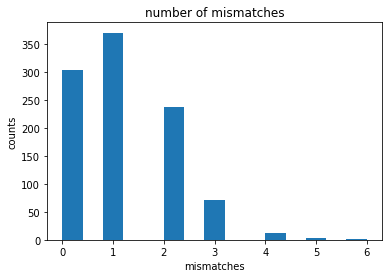

In [30]:
num_samples = 1000
vocabulary = get_all_amino_acids()
num_characters = len(get_all_amino_acids())
index_to_character = dict(zip(range(num_characters), vocabulary))
wild_type = get_wild_type_amino_acid_sequence() 

z = np.random.sample((num_samples, 20))
outputs = vae.decoder(torch.tensor(z).float(), softmax=True)
outputs = outputs.detach().numpy()
print(outputs.shape)
mismatches, all_strings = [], []
for i in range(outputs.shape[0]):
    string = []
    for j in range(outputs.shape[1]):
        k = np.random.choice(list(range(num_characters)), p = outputs[i, j])
        string.append(index_to_character[k])
    all_strings.append("".join(string))
    mismatches.append(count_substring_mismatch(wild_type, all_strings[-1]))
    if i % 100 == 0:
        print("finished {0}/{1} samples".format(i, num_samples))
        
plt.title("number of mismatches")
plt.hist(mismatches, bins=15)
plt.xlabel("mismatches")
plt.ylabel("counts")
plt.savefig("./logs/vae/{0}_mismatches_from_wild_type".format(vae.name))

In [ ]:
if logger:
    logger.close()